In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [2]:
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm
import time
import datetime
import pickle
from torch.utils.data import Dataset, DataLoader
from torcheval.metrics import BinaryAUROC

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
df = pd.read_pickle('/mnt/sda1/projects/rouse_ai/criteo_4M_processed.pkl')

In [4]:
temp = (df.max() + 1).astype(int)
max_all_column = temp.values[:-1]
size_onehot_all_column = max_all_column - np.insert(max_all_column[:-1], 0, 0)
size_vector_onehot = np.sum(size_onehot_all_column)

In [5]:
data_train, data_test = train_test_split(df.values, test_size=0.15, random_state=42)
del df

In [6]:
class CTRDataset(Dataset):

    def __init__(self, data, transform=None):
        self.data_array = data

    def __len__(self):
        return len(self.data_array)

    def __getitem__(self, idx):

        indices = self.data_array[idx][:-1]
        label_ = self.data_array[idx][-1]

        not_zero_indices = torch.LongTensor(indices)
        label_ = torch.Tensor([label_]).type(torch.float32)[0]

        sample = {'one_indices':not_zero_indices, "click": label_}
        
        return sample

In [7]:
# ctr_dataset = CTRDataset(data=data_train)
# dataloader = DataLoader(ctr_dataset, batch_size=4 , shuffle=True, num_workers=0)
# for sample_batched in dataloader:
#     print(sample_batched)
#     break

In [8]:
class ProbToBinary(nn.Module):
    def __init__(self, threshold=0.5):
        super(ProbToBinary, self).__init__()
        self.threshold = threshold
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        x = self.sigmoid(x)
        x[torch.where(x < self.threshold)[0]] = 0
        x[torch.where(x > self.threshold)[0]] = 1
        return x

In [9]:
class DeepFM(nn.Module):
    def __init__(self, size_vector_onehot, num_og_feature, num_factors):
        """
        Deep Factorization Machine model

        Args:
            size_vector_onehot (int): size vector onehot
            num_og_feature (int): num original features
            num_factors (int): size of latent vector
        """

        super(DeepFM, self).__init__()
        self.size_vector_onehot = size_vector_onehot
        self.num_factors = num_factors
        self.embedding = nn.Embedding(size_vector_onehot, num_factors)
        self.linear_layer = nn.Embedding(size_vector_onehot, 1)
        self.bias = nn.Parameter(torch.randn(1), requires_grad=True)
        
        input_deep_size = num_og_feature * num_factors
        num_neurons_hidden_layer = input_deep_size//4 #min(input_deep_size//4, 200)
        num_neurons_last_layer = num_neurons_hidden_layer //4
        self.mlp = nn.Sequential(
            nn.Linear(input_deep_size, num_neurons_hidden_layer),
            nn.BatchNorm1d(num_neurons_hidden_layer),
            nn.ReLU(),
            nn.Dropout(p=0.15),

            nn.Linear(num_neurons_hidden_layer, num_neurons_hidden_layer),
            nn.BatchNorm1d(num_neurons_hidden_layer),
            nn.ReLU(),
            nn.Dropout(p=0.15),

            nn.Linear(num_neurons_hidden_layer, num_neurons_hidden_layer),
            nn.BatchNorm1d(num_neurons_hidden_layer),
            nn.ReLU(),
            nn.Dropout(p=0.15),
            nn.Linear(num_neurons_hidden_layer, 1)
        )
        self.flatten = nn.Flatten(start_dim=1, end_dim=- 1)
        self.weight_FM = nn.Parameter(torch.tensor(0.3), requires_grad=True)

    def forward(self, x):
        """
        Only works for data in batch format
        Args:
            x (array like): (batchsize, one indices)

        Returns:
              feature (torch.Tensor) : (batch_size, num_factors)
        """

        embedded_xs = self.embedding(x)

        # ---------------FM--------------------
        square_of_sum = embedded_xs.sum(1).pow(2).sum(1)
        sum_of_square = embedded_xs.pow(2).sum(1).sum(1)

        degree2_part =  0.5 * (square_of_sum - sum_of_square)
        degree2_part = torch.unsqueeze(degree2_part, -1)

        linear_part = self.linear_layer(x).sum(1) + self.bias
        out_fm = linear_part + degree2_part


        #------------------deep---------------------
        embedded_x_concat = self.flatten(embedded_xs)
        out_deep = self.mlp(embedded_x_concat)


        out = out_fm * torch.abs(self.weight_FM) + out_deep * (1 - torch.abs(self.weight_FM))
        out = out[:, 0]
        return out


In [10]:
batch_size = 128
dataset_train = CTRDataset(data=data_train)
dataset_test = CTRDataset(data=data_test)
loaders = {'train': DataLoader(dataset_train, batch_size, num_workers=10, shuffle=True),
          'val': DataLoader(dataset_test, batch_size, num_workers=10, shuffle=False)}

In [11]:
num_factors=8
model = DeepFM(size_vector_onehot=size_vector_onehot, num_og_feature=data_train.shape[1]-1, num_factors=num_factors)
model = model.to(DEVICE)
ptb = ProbToBinary()

In [12]:
def lr_base_on_epoch(epoch:int):
    if epoch <=5:
        gamma = 0.11
    elif epoch <=10:
        gamma = 0.01
    elif epoch <=20:
        gamma = 1e-3
    elif epoch <=35:
        gamma = 5e-4
    elif epoch <=55:
        gamma = 1e-4
    else:
        gamma = 2e-5
    return gamma

criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1)
lambda_function = lambda epoch: lr_base_on_epoch(epoch=epoch)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda_function)
metric = BinaryAUROC().to(DEVICE)

In [13]:
best_val_score = 0.

In [14]:
logs = []
first_epoch = True
for epoch in range(65):
    current_log = {'epoch': epoch, 'loss_train': 0., 'loss_val': 0., 'val_acc':0., 'val_AUC':0., 'lr': optimizer.param_groups[0]["lr"]}
    start_time = time.time()
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        for sample_batched in loaders[phase]:
            optimizer.zero_grad()

            input_x = sample_batched['one_indices'].to(DEVICE)
            label = sample_batched['click'].to(DEVICE)

            pred = model(input_x)  
            loss = criterion(pred, label)

            current_log[f"loss_{phase}"] += loss.item() * batch_size
            with torch.set_grad_enabled(phase == 'train'):
                if phase == 'train':
                    loss.backward()
                    optimizer.step()
            if phase == 'val':
                with torch.no_grad():
                    metric.update(pred, label)
                    current_log['val_acc'] += (ptb(pred)==label).type(torch.float32).sum(0).item()
        current_log[f"loss_{phase}"] /= len(loaders[phase].dataset)
    current_log['val_acc'] /= len(loaders['val'].dataset)
    current_log['val_AUC'] = metric.compute().item()
    scheduler.step()
    
    if current_log['val_acc'] > best_val_score:
        torch.save(model.state_dict(), 'DeepFM_CTR.pth')
        best_val_score = current_log['val_acc']
    else:
        if epoch < 20:
                if (best_val_score - current_log['val_AUC']) > 0.035:
                    model.load_state_dict(torch.load('DeepFM_CTR.pth'))
        else:
            if (best_val_score - current_log['val_AUC']) > 0.016:
                model.load_state_dict(torch.load('DeepFM_CTR.pth'))

    print(f'Epoch {epoch:3d}   train loss: {current_log["loss_train"]:.4f}  -  val loss: {current_log["loss_val"]:.4f}  -  val accuracy: {current_log["val_acc"]:.4f}  -  val ROC AUC: {current_log["val_AUC"]:.4f}  -  lr: {optimizer.param_groups[0]["lr"]}  -  time: {str(time.time()-start_time)}')
    logs.append(current_log)
    first_epoch = False
pickle.dump(logs, open(f'logs_deepfm_CTR_{str(datetime.datetime.now())}.pkl', 'wb'))

Epoch   0   train loss: 3.4203  -  val loss: 1.3786  -  val accuracy: 0.6545  -  val ROC AUC: 0.6992  -  lr: 0.11  -  time: 405.73966455459595
Epoch   1   train loss: 5.6413  -  val loss: 3.4832  -  val accuracy: 0.6485  -  val ROC AUC: 0.6858  -  lr: 0.11  -  time: 409.32872676849365
Epoch   2   train loss: 7.3985  -  val loss: 8.5393  -  val accuracy: 0.6177  -  val ROC AUC: 0.6625  -  lr: 0.11  -  time: 427.89263558387756
Epoch   3   train loss: 8.8444  -  val loss: 15.2369  -  val accuracy: 0.6280  -  val ROC AUC: 0.6543  -  lr: 0.11  -  time: 430.3495852947235
Epoch   4   train loss: 9.6230  -  val loss: 12.4267  -  val accuracy: 0.6179  -  val ROC AUC: 0.6489  -  lr: 0.11  -  time: 429.569265127182


RuntimeError: CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 23.70 GiB total capacity; 15.61 GiB already allocated; 6.81 MiB free; 15.62 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
loss_trains = np.asarray([logs[i]['loss_train'] for i in range(len(logs))])
loss_vals = np.asarray([logs[i]['loss_val'] for i in range(len(logs))])
val_accs = np.asarray([logs[i]['val_acc'] for i in range(len(logs))])
lrs = np.asarray([logs[i]['lr'] for i in range(len(logs))])

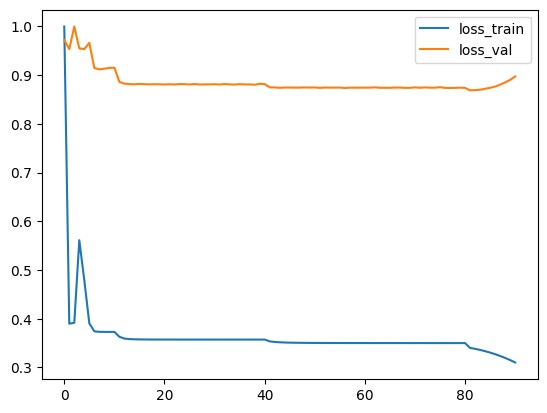

In [ ]:
plt.plot(loss_trains/loss_trains.max(), label='loss_train')
plt.plot(loss_vals/loss_vals.max(), label='loss_val')

plt.legend()

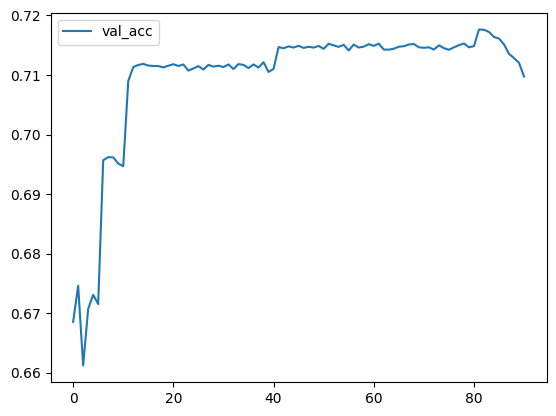

In [ ]:
plt.plot(val_accs, label='val_acc')
plt.legend()

In [ ]:
best_val_score

0.7340576208488161

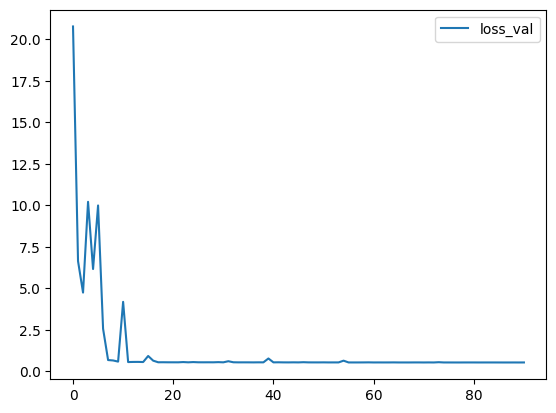

In [ ]:
plt.plot([logs[i]['loss_val'] for i in range(len(logs))], label='loss_val')
plt.legend()

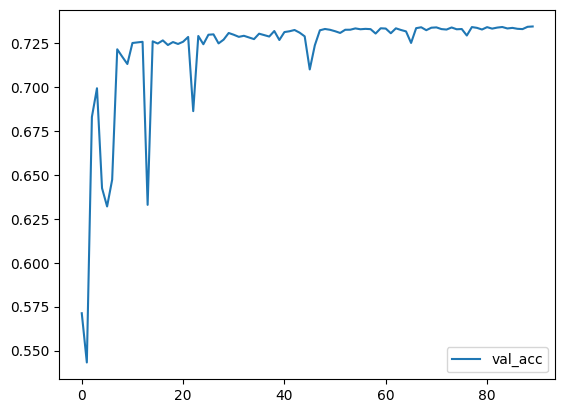

In [ ]:
plt.plot([logs[i]['val_acc'] for i in range(len(logs))], label='val_acc')
# plt.plot([logs[i]['lr'] for i in range(len(logs))], label='lr')
plt.legend()

In [ ]:
# Intel(R) Core(TM) i9-10900X CPU @ 3.70GHz
# NVIDIA GeForce RTX 3090